## Load and Preprocess data

In [ ]:
model_name = "TEdetection_distiBERT_mLM_E3"

### Check for physical devices, if TF is recognizin them

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import shelve
from datetime import datetime
import matplotlib.pyplot as plt
import transformers
print(transformers.__version__)
print(tf.config.list_physical_devices())

In [ ]:
#results = shelve.open(os.path.join("drive", "MyDrive", "Project TE", "data", "prep_trainvalidationtest_1"),'r')
## Needs to fit your path
#e.g. /gxfs_work1/cau/sunam188/Transposon/Boundary_detection_comTEs
#results = shelve.open(os.path.join("gxfs_work1", "cau", "sunam188",  "Transposon", "Boundary_detection_comTEs", "data", "prep_trainvalidationtest_1"),'r')
results = shelve.open(os.path.join("..", "data", "prep_trainvalidationtest_1"),'r')
df = results["chunks"]
tok = results["tokenize_table"]
results.close

np.random.seed(4711)
df = df.sample(frac=1).reset_index(drop=True) # shuffle data


# get length of each chunk
l = []
for row in list(df["attention_masks"]):
  l.append(sum(row))
df["length"] = l

print("number of chunks:", df.shape[0])
print("number of unique tokens in the data: ", len(tok.keys()))
print("length of each chunk in the data: ", len(df["token_ids"].iloc[0]))
print("length of shortest chunk :", df["length"].min())

##eliminate all chunks with only one token

without context an attention mechanism is useless  
additionally, a comTE has a minimum size of 2

In [ ]:
df = df[df["length"] > 1]
print("number of chunks:", df.shape[0])
print("number of unique tokens in the data: ", len(tok.keys()))
print("length of each chunk in the data: ", len(df["token_ids"].iloc[0]))
print("length of shortest chunk :", df["length"].min())

## Build masked training and validation data

In [ ]:
mask_token_id = 1 # to be checked if the model requires another pre-defined token-id

def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 11] = False
    # Set targets to -1 by default, it means ignore
    #labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    #labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    encoded_texts_masked[inp_mask] = mask_token_id
    
    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels


In [ ]:
df_training = df[df["set"] == "training"]["token_ids"]
df_validation = df[df["set"] == "validation"]["token_ids"]

In [ ]:
training_masked, training_labels = get_masked_input_and_labels(np.array([x for x in df_training.tolist()]))
validation_masked, validation_labels = get_masked_input_and_labels(np.array([x for x in df_validation.tolist()]))

In [ ]:
training_attention_mask = np.array([x for x in df[df["set"] == "training"]["attention_masks"]])
validation_attention_mask = np.array([x for x in df[df["set"] == "validation"]["attention_masks"]])

In [9]:
#training_masked[0][0:10]
#training_labels[0][0:10]
#training_attention_mask[0]
#validation_masked[0]
#validation_labels

### Convert the data dictionaries


    there are three possibilities you can use to gather all the input Tensors in the first positional argument :

    a single Tensor with input_ids only and nothing else: model(inputs_ids)
    a list of varying length with one or several input Tensors IN THE ORDER given in the docstring: model([input_ids, attention_mask])
    a dictionary with one or several input Tensors associated to the input names given in the docstring: model({"input_ids": input_ids})


In [ ]:
# data has been reduced to first 100 rows for training and 20 rows for validation.
# This should be changed to the full data as soon as we see the model.fit running without bugs

tf_train_dict = { 'input_ids': tf.convert_to_tensor(training_masked), #[0:100]),
           'attention_mask': tf.convert_to_tensor(training_attention_mask), #[0:100]),
           'labels': tf.convert_to_tensor(training_labels) #[0:100])
         }

tf_val_dict = { 'input_ids': tf.convert_to_tensor(validation_masked), #[0:20]),
           'attention_mask': tf.convert_to_tensor(validation_attention_mask), #[0:20]),
           'labels': tf.convert_to_tensor(validation_labels), #[0:20])
         }

## Functions for saving models and weights

    # Restore the weights
    model.load_weights(path)

    # Evaluate the model
    loss, acc = model.evaluate(test_images, test_labels, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
def save_my_model_weights():
    d = str(datetime.now())
    checkpoint_name = model_name + "-" + d[0:10] + "-" + d[11:13] + "-" + d[14:16]
    checkpoint_dir = os.path.join("..", "models", checkpoint_name)
    model.save_weights(checkpoint_dir)
    return

## Initialize the model
    freshly initialize a DistilBERT model. We’ll use the same configuration for our model as for the distilbert-base-uncased model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and max length of embeddings matches length of our chunks. 


# Load online or offline distilBert:

In [ ]:
from transformers import TFDistilBertForMaskedLM, AutoConfig

############
## ONLINE ##
############
'''
config = AutoConfig.from_pretrained(
    "distilbert-base-uncased",
    vocab_size=len(tok.keys())+11,   # +11 for the reserved special tokens
    max_position_embeddings=len(df["token_ids"].iloc[0])
)
'''
#############
## OFFLINE ##
#############
config_file = "/gxfs_work1/cau/sunam188/Transposon/distilbert-base-uncased/config.json"


config_file = "distilbert-base-uncased/config.json"

config = AutoConfig.from_pretrained(
    config_file,
    vocab_size=len(tok.keys())+11,   # +10 for the reserved special tokens
    max_position_embeddings=len(df["token_ids"].iloc[0])
)

## Load a new (not pretrained) model
Load a new model. Note that we don’t use the from_pretrained() function, since we’re actually initializing a model ourself:

## Compile the model
configure the training hyperparameters and call compile() and fit(). We’ll use a learning rate schedule with some warmup to improve the stability of training:

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    
    model = TFDistilBertForMaskedLM(config)
    model(model.dummy_inputs)  
    model.compile()
    
    num_train_steps = len(training_masked) #[0:100])   ## change this when training with the full data
   
    optimizer, schedule = create_optimizer(
        init_lr=5e-5,
        num_warmup_steps=1_000,
        num_train_steps=num_train_steps,
        weight_decay_rate=0.01,
    )
    
    model.compile(optimizer=optimizer)

### Training 

In [ ]:
#history = model.fit(tf_train_dict, validation_data=tf_val_dict, epochs=3, batch_size = 32, verbose=1)

In [ ]:
#model.save_pretrained("models/MLM_3") 

# Reload model:

In [ ]:
#model = TFDistilBertForMaskedLM.from_pretrained("models/MLM_3")

## Train the model

In [ ]:
#loss = history.history["loss"]
#val_loss = history.history['val_loss']
#print(loss)
#print(val_loss)
loss = []
val_loss = []

In [ ]:
t_p = {   # training parameters
        "nb_all_train_rows": len(training_masked), # rows in training data

        "mini_batch_size": 32, # rows per mini_batch (tensorflow parameter)
        "batch_size": 512, # mini_batches per batch (inner loop)
        "step_size": 1, # batches per step (print progress)
        "epochs": 3, # how many times full data will be processed (outer loop)

        "start_row": 0, # for full data training: start_row = 0
                          # for partial data training: early_stop = x (only from x. rows in data will be used for training)
        "early_stop": 200, # for full data training: early_stop = nb_all_train_rows
                           # for partial data training: early_stop = x (only x rows in data will be used for training)
}
t_p["early_stop"] = t_p["nb_all_train_rows"]
t_p

In [ ]:
steps = (t_p["early_stop"] - t_p["start_row"]) / t_p["mini_batch_size"] / t_p["batch_size"] / t_p["step_size"]
if steps % 1 > 0:
    steps = steps + 1
steps = int(steps)

for epoch in range(0,t_p["epochs"]):
    step = 0
    for start in range(t_p["start_row"], min(t_p["early_stop"]+t_p["start_row"], t_p["nb_all_train_rows"]) , t_p["mini_batch_size"] * t_p["batch_size"]):
        if step % t_p["step_size"] == 0:
            print("epoch", epoch+1, "/", t_p["epochs"], ", step", (step // t_p["step_size"]) + 1, "/", steps)
        step = step + 1    
        end = min(start + t_p["mini_batch_size"] * t_p["batch_size"], min(t_p["early_stop"]+t_p["start_row"], t_p["nb_all_train_rows"])) 
        print ("start/end/length", start, "/", end, "/", end-start)
        mini_batch = { 'input_ids': tf.convert_to_tensor(training_masked[start: end]),
                      'attention_mask': tf.convert_to_tensor(training_attention_mask[start: end]),
                      'labels': tf.convert_to_tensor(training_labels[start: end])
         }

        history = model.fit(mini_batch, validation_data=tf_val_dict, epochs=1, batch_size = t_p["mini_batch_size"], verbose=1) #, callbacks=[callback])
        loss.extend(list(history.history['loss']))
        val_loss.extend(list(history.history['val_loss']))

    save_my_model_weights() # save after each epoch

print("--------------------------- end ---------------------------------")

### Tensorboard

In [ ]:
'''
import tensorboard as tb
#root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir(name: str = ""):
  """
  Prepends time of a run to the specified name of the run.
  This new string (with time prepended) will be used as directory name.
  """
  import time
  run_id = time.strftime("%m_%d-%H_%M")
  run_name = run_id + name
  return os.path.join('../logs', run_name)

tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("MLM_4"), 
                                             histogram_freq=1,)
'''

####Plot training and validation loss per step

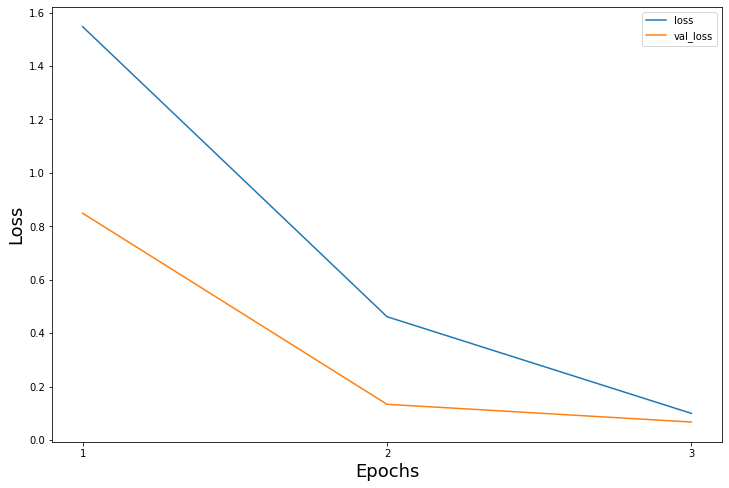

In [30]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(range(1, len(loss)+1),loss)
plt.plot(range(1, len(val_loss)+1),val_loss)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.legend(['loss', 'val_loss'])
plt.xticks([1,2,3])
plt.show()

## Get an output from a pretrained model

# Perplexity

In [62]:
def get_prediction(i, predictions):
    probs = tf.nn.softmax(predictions[0, i])
    result = tf.math.top_k(probs, k=3)
    pred = [result.indices.numpy(), result.values.numpy()]

    return pred

####Restore model
  run this only if necessary

In [ ]:
# Restore the model
break # intensional break

checkpoint_name = "TE_basic_V3-2022-06-01-15-34" # copy paste checkpoint name 
checkpoint_dir = os.path.join("drive", "MyDrive", "Project TE", "models", ".", checkpoint_name)
model.load_weights(checkpoint_dir)

SyntaxError: ignored

#### Define input: Select a single chunk input from data

In [39]:
test_element = 101
input = validation_masked[test_element]
target = validation_labels[test_element]

#### Predict with the pretrained model

In [40]:
outputs = model(input)

#### Evaluate the result

In [41]:
input

array([  583,   582,   581,   580,   579,     1,   577,   576,     1,
         574,   573,   572,   571,   570,   569,   568,   567,   566,
       10102, 17140, 10103,     1,   562,     1,  5588,   560,   559,
         558,   557,   556,   555,   554,   553,   552,   551,   550,
           1,   548,   547,   546,  5590,   545,     1,   543,   542,
         541,   540,   539,     1,   537,     1,   535,   534,   533,
           1,   531,   530,   528,   527,     1,   525,     1,   522,
         521,   520,     1,   518,     1,   516,   515,   514,   513,
         512,   511,   510,   509,   508,   507,   506,   505,     1,
           1,   502,   501,   500,   499,   498,   497,     1,   495,
         480,   479,   478,   477,   476,   475,   474,   473,   472,
         471,   470,   469,   468,   467,     1,   465,   464,   463,
         462,   461,   460,     1,   458,     1,   456,   455,   454,
       10439, 10438, 10030, 10437, 10436, 10435,   453,   452,   451,
         379,   378,

In [66]:
target

array([  583,   582,   581,   580,   579,   578,   577,   576,   575,
         574,   573,   572,   571,   570,   569,   568,   567,   566,
       10102, 17140, 10103,   564,   562,   561,  5588,   560,   559,
         558,   557,   556,   555,   554,   553,   552,   551,   550,
         549,   548,   547,   546,  5590,   545,   544,   543,   542,
         541,   540,   539,   538,   537,   536,   535,   534,   533,
         532,   531,   530,   528,   527,   526,   525,   524,   522,
         521,   520,   519,   518,   517,   516,   515,   514,   513,
         512,   511,   510,   509,   508,   507,   506,   505,   504,
         503,   502,   501,   500,   499,   498,   497,   496,   495,
         480,   479,   478,   477,   476,   475,   474,   473,   472,
         471,   470,   469,   468,   467,   466,   465,   464,   463,
         462,   461,   460,   459,   458,   457,   456,   455,   454,
       10439, 10438, 10030, 10437, 10436, 10435,   453,   452,   451,
         379,   378,

In [67]:
i = 0
for x in input:
    if x == 1:
        print("at position: ", i, 
              "\n\tprediction is:", get_prediction(i, outputs[0])[0],
              "\n\tweight is:", get_prediction(i, outputs[0])[1],
              "\n\ttarget was: ", target[i])
    i = i+1
            

at position:  5 
	prediction is: [578 581 573] 
	weight is: [9.9883777e-01 4.7075839e-04 2.8129146e-04] 
	target was:  578
at position:  8 
	prediction is: [ 575 2080  573] 
	weight is: [9.9628061e-01 2.2761121e-03 5.3364265e-04] 
	target was:  575
at position:  21 
	prediction is: [565 564 563] 
	weight is: [0.46452388 0.2944387  0.14914113] 
	target was:  564
at position:  23 
	prediction is: [ 561 5589  563] 
	weight is: [0.99051636 0.00546949 0.00271413] 
	target was:  561
at position:  36 
	prediction is: [549 548 546] 
	weight is: [9.9998796e-01 2.4211006e-06 2.3203806e-06] 
	target was:  549
at position:  42 
	prediction is: [ 544 5596 9157] 
	weight is: [9.9965191e-01 1.6808271e-04 3.8568764e-05] 
	target was:  544
at position:  48 
	prediction is: [538 536 535] 
	weight is: [9.9927849e-01 6.2826357e-04 1.7137507e-05] 
	target was:  538
at position:  50 
	prediction is: [536 538 540] 
	weight is: [9.9075413e-01 8.8091670e-03 1.2749979e-04] 
	target was:  536
at position:  54 
	

## Log in to huggingface

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


#### Push the model to hub

In [ ]:
from transformers import AutoModel

# Push the model to your namespace with the name model_name and have a local clone in the
# *model_name* folder.
model.push_to_hub(model_name, use_auth_token="...")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='TEdetection_distiBERT_mLM_V2' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:676: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/FritzOS/TEdetection_distiBERT_mLM_V2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/357M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/FritzOS/TEdetection_distiBERT_mLM_V2
   e95f822..aaebda3  main -> main



'https://huggingface.co/FritzOS/TEdetection_distiBERT_mLM_V2/commit/aaebda3b3f120ffd62ed8dbd3d9fd815c224e2b5'